In [1]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [4]:
import sys
import os
from os.path import dirname

UTILS_PATH=os.environ.get('REPO') + "/notebooks/commons"
sys.path.append(dirname(UTILS_PATH))

from commons import check_args, gen_paths
from commons import coordinates_bounds, plot_feature_importances
from commons import check_args_variables, gen_paths_variables

In [5]:
def load_posts(source_path, clean_path):
    external = pd.read_parquet(source_path)
    external.loc[:, "lat"] = external["lat"].apply(float)
    external.loc[:, "lon"] = external["lon"].apply(float)
    
    fincaraiz = pd.read_parquet(clean_path)
    return external, fincaraiz

In [6]:
if __name__ == "__main__":
    source = "OSM"
    city = "manizales"
    
    property_type = "casas"
    post_type = "venta"
    
    base_path = os.environ.get('REPO')
    
    source_path = base_path + gen_paths_variables(source, city)
    raw_path, clean_path = gen_paths(city, property_type, post_type)
        
    raw_path = base_path + raw_path
    clean_path = base_path + clean_path

In [7]:
external_variables, fincaraiz = load_posts(source_path, clean_path)

In [8]:
from math import cos, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
    """
    El resultado de la medición de distancia esta en kilometros.
    """
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a))

def post_to_place_distance(publications, places, index):
    publication = publications.loc[index]
    
    places_to_point = places.copy()
    places_to_point.loc[:, "fid"] = publication["fid"]
    
    places_to_point.loc[:, "latitide"] = publication["latitude"]
    places_to_point.loc[:, "longitude"] = publication["longitude"]
    
    places_to_point.loc[:, "distance"] = places_to_point.apply(
        lambda e: distance(publication["latitude"], publication["longitude"], e["lat"], e["lon"]), axis=1)
        
    return places_to_point

import functools
from multiprocessing import Pool
def get_near_points(external_variables, fincaraiz):    
    distance_map = functools.partial(
        post_to_place_distance, 
        fincaraiz, external_variables)
    
    pool = Pool(8)
    distances = pool.map(
        distance_map,
        fincaraiz.index
    )

    return pd.concat(distances).reset_index(drop=True)

In [9]:
distances_map = get_near_points(external_variables, fincaraiz)
distances_map.head()

,lat,lon,name,amenity,fid,latitide,longitude,distance
0,5.064422,-75.495189,CAI La Leonora,police,5151631,5.06122,-75.472801,2.505162
1,5.064628,-75.497428,101 Perros,fast_food,5151631,5.06122,-75.472801,2.753863
2,5.061315,-75.490434,Universidad de Caldas - Sede Palogrande,university,5151631,5.06122,-75.472801,1.953105
3,5.071657,-75.517147,None,marketplace,5151631,5.06122,-75.472801,5.047045
4,5.066886,-75.504299,Universidad Autónoma de Manizales,university,5151631,5.06122,-75.472801,3.545144


In [10]:
distances_map.loc[distances_map["distance"] == distances_map["distance"].min()]

,lat,lon,name,amenity,fid,latitide,longitude,distance
1183714,5.066981,-75.516797,Biblioteca Luis Ángel Arango,library,5585972,5.066972,-75.516777,0.002425


In [11]:
## Un punto de interes es cercano a la publicicación cuando esta a menos de 3 kilometros

near_points = distances_map.loc[distances_map["distance"] < 3]
near_points.head()

,lat,lon,name,amenity,fid,latitide,longitude,distance
0,5.064422,-75.495189,CAI La Leonora,police,5151631,5.06122,-75.472801,2.505162
1,5.064628,-75.497428,101 Perros,fast_food,5151631,5.06122,-75.472801,2.753863
2,5.061315,-75.490434,Universidad de Caldas - Sede Palogrande,university,5151631,5.06122,-75.472801,1.953105
5,5.063438,-75.499609,Universidad de Caldas - Facultad de Ciencias p...,university,5151631,5.06122,-75.472801,2.979496
6,5.062827,-75.497807,Clínica Versalles,hospital,5151631,5.06122,-75.472801,2.775396


In [12]:
near_points.describe()

,lat,lon,latitide,longitude,distance
count,732903.000000,732903.000000,732903.000000,732903.000000,732903.000000
mean,5.060425,-75.503026,5.060623,-75.501686,1.708039
std,0.008907,0.014622,0.010789,0.015489,0.786284
min,5.017551,-75.554942,5.019469,-75.554764,0.002425
25%,5.055756,-75.514954,5.053070,-75.513817,1.075933
50%,5.062957,-75.505462,5.062950,-75.501266,1.742997
75%,5.067220,-75.489257,5.067815,-75.489807,2.385075
max,5.096118,-75.445525,5.110040,-75.443680,2.999999


In [13]:
near_points_by_categories = near_points[["fid", "amenity", "name"]].groupby(["fid", "amenity"]).count()
near_points_by_categories.head()

name
fid     amenity              
1274344 atm                 0
        bank               18
        bar                11
        bench               0
        bicycle_parking     0

In [14]:
index = list(zip(*near_points_by_categories.index))
near_points_by_categories.loc[:, "fid"] = index[0]
near_points_by_categories.loc[:, "amenity"] = index[1]
near_points_by_categories.loc[:, "count"] = near_points_by_categories["name"]

near_points_by_categories = near_points_by_categories.reset_index(drop=True)
near_points_by_categories = near_points_by_categories.drop(["name"], axis=1)
near_points_by_categories.head()

,fid,amenity,count
0,1274344,atm,0
1,1274344,bank,18
2,1274344,bar,11
3,1274344,bench,0
4,1274344,bicycle_parking,0


In [15]:
posts_full = fincaraiz[["fid"]].copy()
posts_full = posts_full.drop_duplicates(["fid"])

def safe_get(post, amenity):
    client = near_points_by_categories.loc[
        near_points_by_categories["fid"] == post["fid"]]
    
    if client.shape[0] == 0:
        return 0
    
    client = client.loc[client["amenity"] == amenity]
    if client.shape[0] == 0:
        return 0
    
    return client["count"].iloc[0]

In [16]:
for amenity in external_variables["amenity"].value_counts().index:
    posts_full.loc[:, amenity] = posts_full.apply(lambda e: safe_get(e, amenity), axis=1)

In [20]:
## Las features y las etiquetas son las mismas en todos los métodos

FEATURES = list(filter(lambda e: e != "fid", posts_full.columns))
LABEL = "price"

final_features = pd.merge(posts_full, fincaraiz[["fid", "price"]], on="fid")

X = final_features[FEATURES].values
y = final_features[LABEL].values

## Selección de features univariada

In [21]:
selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(X, y)
X_new.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


(1992, 5)

In [22]:
feature_importances = pd.DataFrame({'importance': selector.scores_, 'feature': FEATURES})

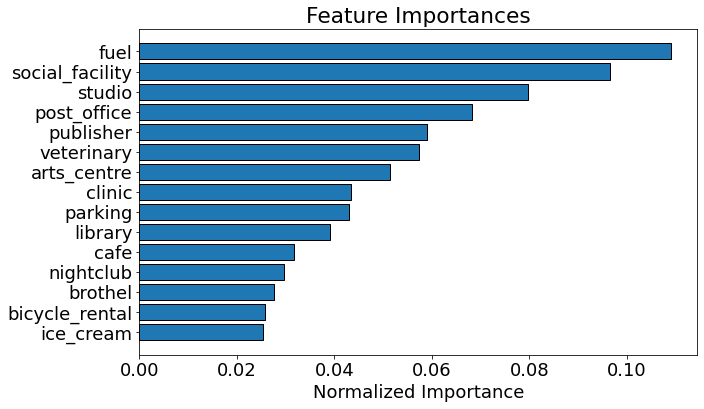

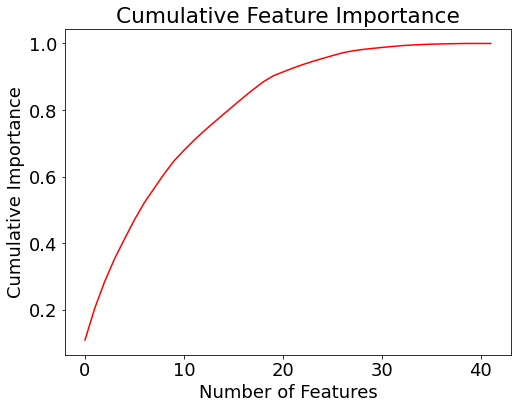

20 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,8,82.136097,fuel,0.109084,0.109084
1,38,72.722178,social_facility,0.096581,0.205665
2,47,60.104507,studio,0.079824,0.285489
3,14,51.419195,post_office,0.068289,0.353779
4,53,44.510199,publisher,0.059113,0.412892
5,25,43.201326,veterinary,0.057375,0.470267
6,46,38.781971,arts_centre,0.051506,0.521773
7,35,32.724165,clinic,0.043461,0.565234
8,11,32.393700,parking,0.043022,0.608255
9,30,29.426508,library,0.039081,0.647336


In [23]:
plot_feature_importances(feature_importances)

## Eliminación recursiva de features

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [25]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.18338816161534743

In [26]:
rfe = RFE(estimator=reg, n_features_to_select=1, step=1)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [27]:
feature_importances = pd.DataFrame({'importance': rfe.ranking_, 'feature': FEATURES})

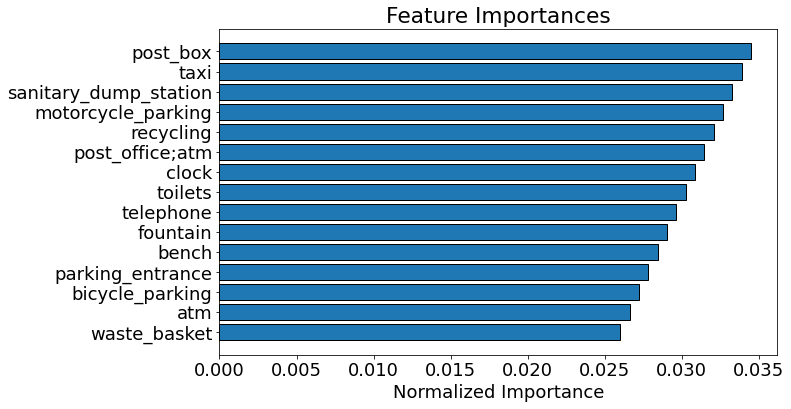

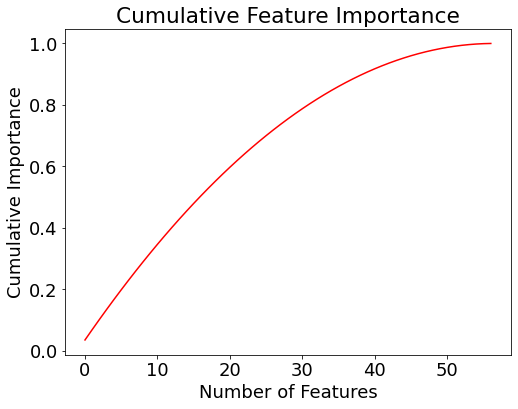

40 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,43,57,post_box,0.034483,0.034483
1,27,56,taxi,0.033878,0.068361
2,45,55,sanitary_dump_station,0.033273,0.101633
3,51,54,motorcycle_parking,0.032668,0.134301
4,37,53,recycling,0.032063,0.166364
5,52,52,post_office;atm,0.031458,0.197822
6,24,51,clock,0.030853,0.228675
7,22,50,toilets,0.030248,0.258923
8,0,49,telephone,0.029643,0.288566
9,19,48,fountain,0.029038,0.317604


In [28]:
plot_feature_importances(feature_importances)

## Selección de features basada en arboles

In [29]:
from sklearn.ensemble import ExtraTreesRegressor

In [30]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(X, y)

ExtraTreesRegressor(random_state=0)

In [31]:
feature_importances = pd.DataFrame({'importance':  forest.feature_importances_, 'feature': FEATURES})

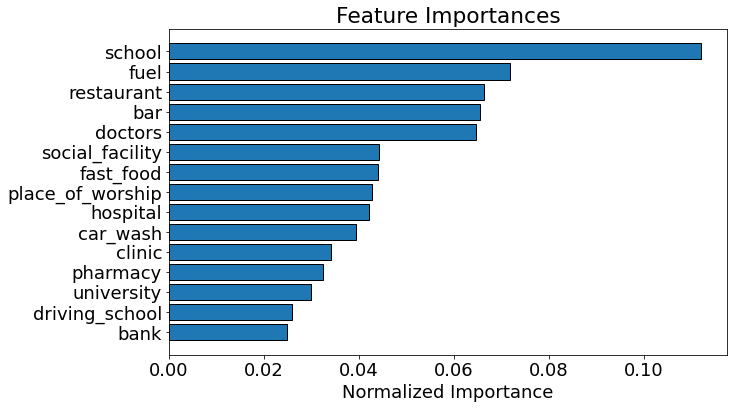

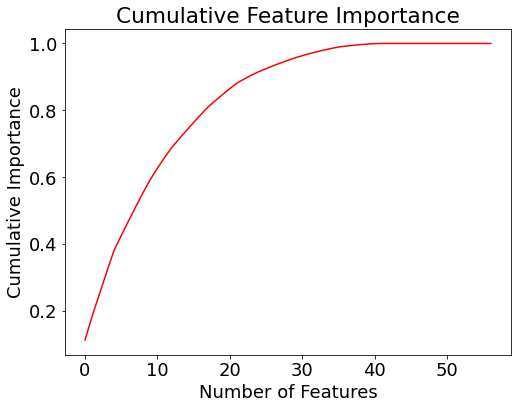

24 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,10,0.111907,school,0.111907,0.111907
1,8,0.071735,fuel,0.071735,0.183642
2,2,0.066295,restaurant,0.066295,0.249937
3,12,0.065405,bar,0.065405,0.315342
4,23,0.064543,doctors,0.064543,0.379885
5,38,0.044156,social_facility,0.044156,0.424041
6,4,0.043958,fast_food,0.043958,0.467999
7,9,0.042703,place_of_worship,0.042703,0.510702
8,16,0.042155,hospital,0.042155,0.552857
9,20,0.039420,car_wash,0.039420,0.592277


In [32]:
plot_feature_importances(feature_importances)